In [1]:
#DESCARGAMOS LOS MODULOS PARA PODER CORRER EL SCRIPT
import pandas as pd
import numpy as np
import requests
import config
import time
from datetime import datetime, date, timedelta
from scipy import stats
import matplotlib.pyplot as plt
import sys
import pickle
import functions as fn
from redash import get_info_redash
from analystcommunity import read_connection_data_warehouse as read_dw,connections_utils as cu,sheets
import datetime
from datetime import datetime,time,date,timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
import time
import glob
import math

Vamos a correr primero la data total de bonus, que fue tomada del INEGI

In [2]:
#JUNTAMOS TODOS LOS ARCHIVOS EN UNO SOLO
folder='./bonus'
allFiles = glob.glob(folder + "/*.xlsx")
list_ = []
for file_ in allFiles:
    df = pd.read_excel(file_)
    list_.append(df)
frame = pd.concat(list_)
print(frame)

   Instituto Nacional de Estadística y Geografía (INEGI)  \
0   Población total por entidad federativa y grupo...      
1                                                 NaN      
2                                  Entidad federativa      
3                                  Entidad federativa      
4                            Estados Unidos Mexicanos      
..                                                ...      
65                    Veracruz de Ignacio de la Llave      
66                                            Yucatán      
67                                            Yucatán      
68                                          Zacatecas      
69                                          Zacatecas      

                  Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  
0                        NaN        NaN        NaN        NaN  
1                        NaN        NaN        NaN        NaN  
2   Grupo quinquenal de edad       2020       2020       2020  
3   Grupo quinquenal de

In [3]:
frame.head()

,Instituto Nacional de Estadística y Geografía (INEGI),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Población total por entidad federativa y grupo...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,Entidad federativa,Grupo quinquenal de edad,2020,2020,2020
3,Entidad federativa,Grupo quinquenal de edad,Total,Hombres,Mujeres
4,Estados Unidos Mexicanos,15 a 19 años,10806690,5462150,5344540


In [4]:
#NOMBRAMOS LAS COLUMANS PARA PODER EMEZAR A CONSTRUIR LA DB
frames = frame.rename(columns = {'Instituto Nacional de Estadística y Geografía (INEGI)': 'ENTIDAD_FEDERATIVA','Unnamed: 1': 'Grupo_de_Edad',
                        'Unnamed: 2' : 'Total_2020', 'Unnamed: 3':'Hombres', 'Unnamed: 4' : 'Mujeres '})

In [5]:
#ELIMINAMOS EL IDEX O,1,2 QUE SON TEXTO QUE NO NOS VA A SERVIR
frames = frames.drop([0,1,2,3])

In [6]:
frames.head()

,ENTIDAD_FEDERATIVA,Grupo_de_Edad,Total_2020,Hombres,Mujeres
4,Estados Unidos Mexicanos,15 a 19 años,10806690,5462150,5344540
5,Estados Unidos Mexicanos,20 a 24 años,10422095,5165884,5256211
6,Aguascalientes,15 a 19 años,131967,66903,65064
7,Aguascalientes,20 a 24 años,127020,63154,63866
8,Baja California,15 a 19 años,315639,161298,154341


In [7]:
frames.columns

Index(['ENTIDAD_FEDERATIVA', 'Grupo_de_Edad', 'Total_2020', 'Hombres',
       'Mujeres '],
      dtype='object')

Hasta este punto, la data ya esta limpia, proseguimos con las preguntas de bonus

BONUS QUESTION
1. What is the target population size for the asset? (Undergraduate = 18 to 24 years of age).

In [8]:
frames['Total_Procesado'] = frames['Total_2020']/5
frames['Total_Procesado_Hombres'] = frames['Hombres']/5
frames['Total_Procesado_Mujeres'] = frames['Mujeres ']/5
#frames['2020_Total'] = frames['Total_Procesado'] + frames['Total_2020']
#frames['2020_Hombres'] = frames['Total_Procesado_Hombres'] + frames['Hombres']
#frames['2020_Mujeres'] = frames['Total_Procesado_Mujeres'] + frames['Mujeres ']

frames

,ENTIDAD_FEDERATIVA,Grupo_de_Edad,Total_2020,Hombres,Mujeres,Total_Procesado,Total_Procesado_Hombres,Total_Procesado_Mujeres
4,Estados Unidos Mexicanos,15 a 19 años,10806690,5462150,5344540,2161338.0,1092430.0,1068908.0
5,Estados Unidos Mexicanos,20 a 24 años,10422095,5165884,5256211,2084419.0,1033176.8,1051242.2
6,Aguascalientes,15 a 19 años,131967,66903,65064,26393.4,13380.6,13012.8
7,Aguascalientes,20 a 24 años,127020,63154,63866,25404.0,12630.8,12773.2
8,Baja California,15 a 19 años,315639,161298,154341,63127.8,32259.6,30868.2
...,...,...,...,...,...,...,...,...
65,Veracruz de Ignacio de la Llave,20 a 24 años,600394,292359,308035,120078.8,58471.8,61607.0
66,Yucatán,15 a 19 años,196363,99417,96946,39272.6,19883.4,19389.2
67,Yucatán,20 a 24 años,199525,100085,99440,39905.0,20017.0,19888.0
68,Zacatecas,15 a 19 años,141208,70860,70348,28241.6,14172.0,14069.6


In [9]:
#TABLA1 ELIMINAMOS LA ULTIMA FILA DE CADA ARCHIVO
filtrar = frames['Grupo_de_Edad']== '15 a 19 años'
frames1 = frames.drop(index=frames[filtrar].index)
frames1 = frames1[['ENTIDAD_FEDERATIVA','Grupo_de_Edad','Total_2020','Hombres','Mujeres ']]
frames1.head()

,ENTIDAD_FEDERATIVA,Grupo_de_Edad,Total_2020,Hombres,Mujeres
5,Estados Unidos Mexicanos,20 a 24 años,10422095,5165884,5256211
7,Aguascalientes,20 a 24 años,127020,63154,63866
9,Baja California,20 a 24 años,340359,173450,166909
11,Baja California Sur,20 a 24 años,66743,34418,32325
13,Campeche,20 a 24 años,75556,37277,38279


In [10]:
#TABLA1 ELIMINAMOS LA ULTIMA FILA DE CADA ARCHIVO
filtrar = frames['Grupo_de_Edad']== '20 a 24 años'
frames2 = frames.drop(index=frames[filtrar].index)
frames2 = frames2[['ENTIDAD_FEDERATIVA','Grupo_de_Edad','Total_Procesado','Total_Procesado_Hombres','Total_Procesado_Mujeres']]
frames2.head()

,ENTIDAD_FEDERATIVA,Grupo_de_Edad,Total_Procesado,Total_Procesado_Hombres,Total_Procesado_Mujeres
4,Estados Unidos Mexicanos,15 a 19 años,2161338.0,1092430.0,1068908.0
6,Aguascalientes,15 a 19 años,26393.4,13380.6,13012.8
8,Baja California,15 a 19 años,63127.8,32259.6,30868.2
10,Baja California Sur,15 a 19 años,13093.8,6757.6,6336.2
12,Campeche,15 a 19 años,15228.0,7693.6,7534.4


In [11]:
bonus =pd.merge(frames1, frames2, on = 'ENTIDAD_FEDERATIVA', how='left')
bonus.head()

,ENTIDAD_FEDERATIVA,Grupo_de_Edad_x,Total_2020,Hombres,Mujeres,Grupo_de_Edad_y,Total_Procesado,Total_Procesado_Hombres,Total_Procesado_Mujeres
0,Estados Unidos Mexicanos,20 a 24 años,10422095,5165884,5256211,15 a 19 años,2161338.0,1092430.0,1068908.0
1,Aguascalientes,20 a 24 años,127020,63154,63866,15 a 19 años,26393.4,13380.6,13012.8
2,Baja California,20 a 24 años,340359,173450,166909,15 a 19 años,63127.8,32259.6,30868.2
3,Baja California Sur,20 a 24 años,66743,34418,32325,15 a 19 años,13093.8,6757.6,6336.2
4,Campeche,20 a 24 años,75556,37277,38279,15 a 19 años,15228.0,7693.6,7534.4


In [12]:
bonus['Total_Final'] = ((bonus['Total_Procesado']*2) + bonus['Total_2020'])
bonus['2020_Hombres'] = ((bonus['Total_Procesado_Hombres']*2) + bonus['Hombres'])
bonus['2020_Mujeres'] = ((bonus['Total_Procesado_Mujeres']*2) + bonus['Mujeres '])
#bonus = bonus[['ENTIDAD_FEDERATIVA','2020_Total','2020_Hombres','2020_Mujeres']]
bonus.head()

,ENTIDAD_FEDERATIVA,Grupo_de_Edad_x,Total_2020,Hombres,Mujeres,Grupo_de_Edad_y,Total_Procesado,Total_Procesado_Hombres,Total_Procesado_Mujeres,Total_Final,2020_Hombres,2020_Mujeres
0,Estados Unidos Mexicanos,20 a 24 años,10422095,5165884,5256211,15 a 19 años,2161338.0,1092430.0,1068908.0,14744771.0,7350744.0,7394027.0
1,Aguascalientes,20 a 24 años,127020,63154,63866,15 a 19 años,26393.4,13380.6,13012.8,179806.8,89915.2,89891.6
2,Baja California,20 a 24 años,340359,173450,166909,15 a 19 años,63127.8,32259.6,30868.2,466614.6,237969.2,228645.4
3,Baja California Sur,20 a 24 años,66743,34418,32325,15 a 19 años,13093.8,6757.6,6336.2,92930.6,47933.2,44997.4
4,Campeche,20 a 24 años,75556,37277,38279,15 a 19 años,15228.0,7693.6,7534.4,106012.0,52664.2,53347.8


In [13]:
decimals = 0   
bonus['Total_Final'] = bonus['Total_Final'].apply(lambda x: round(x, decimals))
bonus['2020_Hombres'] = bonus['2020_Hombres'].apply(lambda x: round(x, decimals))
bonus['2020_Mujeres'] = bonus['2020_Hombres'].apply(lambda x: round(x, decimals))
bonus = bonus[['ENTIDAD_FEDERATIVA','Total_Final','2020_Hombres','2020_Mujeres']]
bonus.head()

,ENTIDAD_FEDERATIVA,Total_Final,2020_Hombres,2020_Mujeres
0,Estados Unidos Mexicanos,14744771.0,7350744.0,7350744.0
1,Aguascalientes,179807.0,89915.0,89915.0
2,Baja California,466615.0,237969.0,237969.0
3,Baja California Sur,92931.0,47933.0,47933.0
4,Campeche,106012.0,52664.0,52664.0


In [14]:
bonus.sort_values(by=['Total_Final'],inplace=True,ascending=False)


In [15]:
bonusgraf = bonus.loc[~bonus['ENTIDAD_FEDERATIVA'].isin(['Estados Unidos Mexicanos'])]
bonusgraf = bonusgraf.head(10)
bonusgraf

,ENTIDAD_FEDERATIVA,Total_Final,2020_Hombres,2020_Mujeres
15,México,2005825.0,1004470.0,1004470.0
14,Jalisco,990863.0,497100.0,497100.0
9,Ciudad de México,974761.0,491493.0,491493.0
30,Veracruz de Ignacio de la Llave,873013.0,430020.0,430020.0
21,Puebla,813526.0,401705.0,401705.0
11,Guanajuato,761424.0,378339.0,378339.0
19,Nuevo León,692584.0,351629.0,351629.0
7,Chiapas,675154.0,328740.0,328740.0
16,Michoacán de Ocampo,553528.0,273515.0,273515.0
2,Baja California,466615.0,237969.0,237969.0


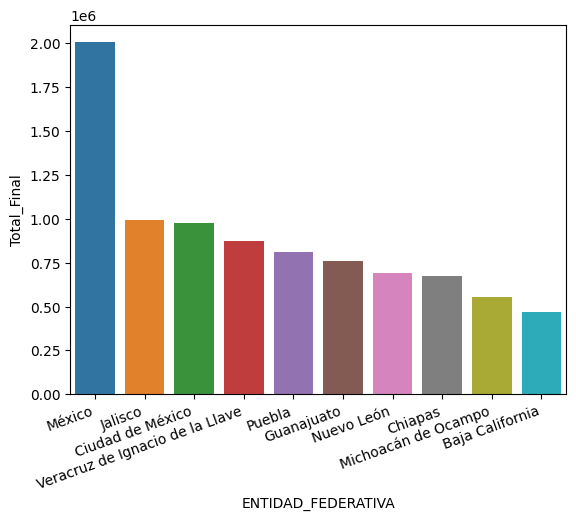

In [16]:
sns.barplot(x = 'ENTIDAD_FEDERATIVA', y = 'Total_Final', data = bonusgraf)
 
# Show the plot
plt.xticks(rotation = 20, ha = 'right')
plt.show()

BONUS QUESTION 
2. What is the market penetration in the geographical areas where the asset is located? (Penetration =
Enrollments / Target population)
3. What do these KPIs (1 and 2) tell you about market opportunities?

In [17]:
framesfinal = pd.read_excel('FRAMES_FINAL.xlsx')

In [18]:
#En primer lugar, se va a filtrar la base de datos solo para la UVM, y para el ciclo 2020-2021
framesUVM=framesfinal[framesfinal["INSTITUCIÓN_DE_EDUCACIÓN_SUPERIOR"] == 'UNIVERSIDAD DEL VALLE DE MÉXICO'] 
framesUVM=framesUVM[framesUVM["CICLO"] == '2020_2021'] 
framesUVM=framesUVM[framesUVM["TIPO"] == 'Licenciatura'] 
framesUVM.head()

,Unnamed: 0,ENTIDAD_FEDERATIVA,MUNICIPIO,INSTITUCIÓN_DE_EDUCACIÓN_SUPERIOR,ESCUELA,PROGRAMA_DE_ESTUDIOS,MATRICULA_MUJERES,MATRICULA_HOMBRES,MATRICULA_TOTAL,PRIMER_INGRESO_MUJERES,PRIMER_INGRESO_HOMBRES,PRIMER_INGRESO_TOTAL,LUGARES_OFERTADOS_TOTAL,MODALIDAD,INSTITUCION,CICLO,TIPO
41484,105,AGUASCALIENTES,AGUASCALIENTES,UNIVERSIDAD DEL VALLE DE MÉXICO,UNIVERSIDAD DEL VALLE DE MÉXICO - CAMPUS AGUAS...,ARQUITECTURA,9,14,23,0,0,0,20,Escolarizada,Particular,2020_2021,Licenciatura
41485,106,AGUASCALIENTES,AGUASCALIENTES,UNIVERSIDAD DEL VALLE DE MÉXICO,UNIVERSIDAD DEL VALLE DE MÉXICO - CAMPUS AGUAS...,INGENIERÍA EN MECATRÓNICA,2,9,11,0,0,0,20,Escolarizada,Particular,2020_2021,Licenciatura
41486,107,AGUASCALIENTES,AGUASCALIENTES,UNIVERSIDAD DEL VALLE DE MÉXICO,UNIVERSIDAD DEL VALLE DE MÉXICO - CAMPUS AGUAS...,LICENCIATURA EN ADMINISTRACIÓN,2,10,12,0,0,0,10,Escolarizada,Particular,2020_2021,Licenciatura
41487,108,AGUASCALIENTES,AGUASCALIENTES,UNIVERSIDAD DEL VALLE DE MÉXICO,UNIVERSIDAD DEL VALLE DE MÉXICO - CAMPUS AGUAS...,LICENCIATURA EN ADMINISTRACIÓN DE EMPRESAS,2,10,12,0,0,0,20,Escolarizada,Particular,2020_2021,Licenciatura
41488,109,AGUASCALIENTES,AGUASCALIENTES,UNIVERSIDAD DEL VALLE DE MÉXICO,UNIVERSIDAD DEL VALLE DE MÉXICO - CAMPUS AGUAS...,LICENCIATURA EN ADMINISTRACIÓN DE NEGOCIOS INT...,20,27,47,7,6,13,20,Escolarizada,Particular,2020_2021,Licenciatura


In [19]:
#Se obtienen los estados en los que esta la UVM
pivot1 = pd.pivot_table(data=framesUVM,index='ENTIDAD_FEDERATIVA', values = 'MATRICULA_TOTAL', aggfunc = 'sum',margins = True,margins_name = 'Total')
#pivot1.sort_values(by=['Total'], ascending = False)
pivot1
#len(pivot1)
#pivot1

,MATRICULA_TOTAL
ENTIDAD_FEDERATIVA,
AGUASCALIENTES,565
BAJA CALIFORNIA,652
CHIAPAS,949
CHIHUAHUA,1335
CIUDAD DE MÉXICO,22938
COAHUILA,1374
JALISCO,2929
MORELOS,704
MÉXICO,13567


In [20]:
#Se acomoda la tabla por ENTIDAD FEDERATIVA DE MAYOR A MENOR PARA ENTENDER LA DISTRUBICION DE ESTUDIANTES
pivot1.sort_values(by=['MATRICULA_TOTAL'], ascending = False, inplace = True)
pivot1

,MATRICULA_TOTAL
ENTIDAD_FEDERATIVA,
Total,65164
CIUDAD DE MÉXICO,22938
MÉXICO,13567
NUEVO LEÓN,5288
QUERÉTARO,4183
JALISCO,2929
TABASCO,2607
TAMAULIPAS,2261
SONORA,2200


In [21]:
#LA TABLA PIVOTE DE ESTADOS SE HACE TABLA NORMAL PARA PODER MANIPULAR LA DATA
estados = pivot1.reset_index()
#escuelas.sort_values(by=['Total'],inplace=True,ascending=False)
estados

,ENTIDAD_FEDERATIVA,MATRICULA_TOTAL
0,Total,65164
1,CIUDAD DE MÉXICO,22938
2,MÉXICO,13567
3,NUEVO LEÓN,5288
4,QUERÉTARO,4183
5,JALISCO,2929
6,TABASCO,2607
7,TAMAULIPAS,2261
8,SONORA,2200
9,COAHUILA,1374


In [22]:
#SE TOMAN LAS COLUMNAS A ANALIZAR
bonus3 = bonus[['ENTIDAD_FEDERATIVA','Total_Final']]
bonus3

,ENTIDAD_FEDERATIVA,Total_Final
0,Estados Unidos Mexicanos,14744771.0
15,México,2005825.0
14,Jalisco,990863.0
9,Ciudad de México,974761.0
30,Veracruz de Ignacio de la Llave,873013.0
21,Puebla,813526.0
11,Guanajuato,761424.0
19,Nuevo León,692584.0
7,Chiapas,675154.0
16,Michoacán de Ocampo,553528.0


In [23]:
#se cambia el texto para despues poder hacer el merge
bonus3['ENTIDAD_FEDERATIVA'] = bonus3['ENTIDAD_FEDERATIVA'].str.upper()
bonus3

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ENTIDAD_FEDERATIVA,Total_Final
0,ESTADOS UNIDOS MEXICANOS,14744771.0
15,MÉXICO,2005825.0
14,JALISCO,990863.0
9,CIUDAD DE MÉXICO,974761.0
30,VERACRUZ DE IGNACIO DE LA LLAVE,873013.0
21,PUEBLA,813526.0
11,GUANAJUATO,761424.0
19,NUEVO LEÓN,692584.0
7,CHIAPAS,675154.0
16,MICHOACÁN DE OCAMPO,553528.0


In [24]:
#SE CAMBIA EL NOMBRE PARA DESPUES PODER HACER EL MERGE
bonus3.replace("VERACRUZ DE IGNACIO DE LA LLAVE",  "VERACRUZ",  inplace=True)
bonus3

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,ENTIDAD_FEDERATIVA,Total_Final
0,ESTADOS UNIDOS MEXICANOS,14744771.0
15,MÉXICO,2005825.0
14,JALISCO,990863.0
9,CIUDAD DE MÉXICO,974761.0
30,VERACRUZ,873013.0
21,PUEBLA,813526.0
11,GUANAJUATO,761424.0
19,NUEVO LEÓN,692584.0
7,CHIAPAS,675154.0
16,MICHOACÁN DE OCAMPO,553528.0


In [25]:
#SE CAMBIA EL NOMBRE PARA DESPUES PODER HACER EL MERGE
bonus3.replace("COAHUILA DE ZARAGOZA",  "COAHUILA",  inplace=True)
bonus3

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,ENTIDAD_FEDERATIVA,Total_Final
0,ESTADOS UNIDOS MEXICANOS,14744771.0
15,MÉXICO,2005825.0
14,JALISCO,990863.0
9,CIUDAD DE MÉXICO,974761.0
30,VERACRUZ,873013.0
21,PUEBLA,813526.0
11,GUANAJUATO,761424.0
19,NUEVO LEÓN,692584.0
7,CHIAPAS,675154.0
16,MICHOACÁN DE OCAMPO,553528.0


In [26]:
#En primer lugar, se va a filtrar la base de datos solo para undergraduates, y para el ciclo 2020-2021
frames_pen=framesfinal[framesfinal["TIPO"] == 'Licenciatura'] 
frames_pen=frames_pen[frames_pen["CICLO"] == '2020_2021'] 
frames_pen.head()

,Unnamed: 0,ENTIDAD_FEDERATIVA,MUNICIPIO,INSTITUCIÓN_DE_EDUCACIÓN_SUPERIOR,ESCUELA,PROGRAMA_DE_ESTUDIOS,MATRICULA_MUJERES,MATRICULA_HOMBRES,MATRICULA_TOTAL,PRIMER_INGRESO_MUJERES,PRIMER_INGRESO_HOMBRES,PRIMER_INGRESO_TOTAL,LUGARES_OFERTADOS_TOTAL,MODALIDAD,INSTITUCION,CICLO,TIPO
40314,4,AGUASCALIENTES,AGUASCALIENTES,INSTITUTO TECNOLÓGICO DE AGUASCALIENTES,INSTITUTO TECNOLÓGICO DE AGUASCALIENTES,INGENIERÍA EN GESTIÓN EMPRESARIAL,58,46,104,11,10,21,125,NoEscolarizada,Publico,2020_2021,Licenciatura
40315,5,AGUASCALIENTES,AGUASCALIENTES,INSTITUTO TECNOLÓGICO DE AGUASCALIENTES,INSTITUTO TECNOLÓGICO DE AGUASCALIENTES,INGENIERÍA EN SISTEMAS DE COMPUTACIÓN,0,4,4,0,0,0,0,NoEscolarizada,Publico,2020_2021,Licenciatura
40316,6,AGUASCALIENTES,AGUASCALIENTES,INSTITUTO TECNOLÓGICO DE AGUASCALIENTES,INSTITUTO TECNOLÓGICO DE AGUASCALIENTES,INGENIERÍA INDUSTRIAL,73,199,272,11,27,38,160,NoEscolarizada,Publico,2020_2021,Licenciatura
40317,9,AGUASCALIENTES,AGUASCALIENTES,UNIDAD U.P.N. 011 AGUASCALIENTES,UNIDAD U.P.N. 011 AGUASCALIENTES,LICENCIATURA EN EDUCACIÓN E INNOVACIÓN PEDAGÓGICA,47,13,60,21,7,28,28,NoEscolarizada,Publico,2020_2021,Licenciatura
40318,10,AGUASCALIENTES,PABELLÓN DE ARTEAGA,INSTITUTO TECNOLÓGICO DE PABELLÓN DE ARTEAGA,INSTITUTO TECNOLÓGICO DE PABELLÓN DE ARTEAGA,INGENIERÍA EN GESTIÓN EMPRESARIAL,303,173,476,61,24,85,120,NoEscolarizada,Publico,2020_2021,Licenciatura


In [27]:
#Se hace la pivote
pivot2 = pd.pivot_table(data=frames_pen,index='ENTIDAD_FEDERATIVA', values = 'MATRICULA_TOTAL', aggfunc = 'sum',margins = True,margins_name = 'Total')
#pivot1.sort_values(by=['Total'], ascending = False)
pivot2
#len(pivot1)
#pivot1

,MATRICULA_TOTAL
ENTIDAD_FEDERATIVA,
AGUASCALIENTES,59304
BAJA CALIFORNIA,139677
BAJA CALIFORNIA SUR,24337
CAMPECHE,31476
CHIAPAS,110225
CHIHUAHUA,136395
CIUDAD DE MÉXICO,735786
COAHUILA,123329
COLIMA,25035


In [28]:
#LA TABLA PIVOTE DE ESTADOS SE HACE TABLA NORMAL PARA PODER MANIPULAR LA DATA
frames_pen = pivot2.reset_index()
#escuelas.sort_values(by=['Total'],inplace=True,ascending=False)
frames_pen

,ENTIDAD_FEDERATIVA,MATRICULA_TOTAL
0,AGUASCALIENTES,59304
1,BAJA CALIFORNIA,139677
2,BAJA CALIFORNIA SUR,24337
3,CAMPECHE,31476
4,CHIAPAS,110225
5,CHIHUAHUA,136395
6,CIUDAD DE MÉXICO,735786
7,COAHUILA,123329
8,COLIMA,25035
9,DURANGO,54939


In [29]:
#SE SACA EL NUMERO TOTAL DE ESTUDIANTES POR ESTADO, ELIGIENDO SOLO LOS ESTADOS EN LOS QUE ESTA LA UVM
bonus_penetration =pd.merge(estados,frames_pen, on = 'ENTIDAD_FEDERATIVA', how='left')
bonus_penetration = bonus_penetration[['ENTIDAD_FEDERATIVA','MATRICULA_TOTAL_y']]
bonus_penetration

,ENTIDAD_FEDERATIVA,MATRICULA_TOTAL_y
0,Total,4566376
1,CIUDAD DE MÉXICO,735786
2,MÉXICO,500820
3,NUEVO LEÓN,257036
4,QUERÉTARO,91102
5,JALISCO,266178
6,TABASCO,85281
7,TAMAULIPAS,133333
8,SONORA,123853
9,COAHUILA,123329


In [30]:
#Se hace el merge entre los undergraduate students y los jovenes de ese rango de edad
bonus_penetration_states =pd.merge(bonus_penetration, bonus3, on = 'ENTIDAD_FEDERATIVA', how='left')
bonus_penetration_states
bonus_penetration_states.dropna(inplace=True)
bonus_penetration_states

,ENTIDAD_FEDERATIVA,MATRICULA_TOTAL_y,Total_Final
1,CIUDAD DE MÉXICO,735786,974761.0
2,MÉXICO,500820,2005825.0
3,NUEVO LEÓN,257036,692584.0
4,QUERÉTARO,91102,288295.0
5,JALISCO,266178,990863.0
6,TABASCO,85281,272019.0
7,TAMAULIPAS,133333,402044.0
8,SONORA,123853,349289.0
9,COAHUILA,123329,372027.0
10,CHIHUAHUA,136395,444600.0


In [31]:
#SE SACA LA PENETRACION
bonus_penetration_states['PENETRATION'] = round((bonus_penetration_states['MATRICULA_TOTAL_y']/bonus_penetration_states['Total_Final'])*100) 
bonus_penetration_states.sort_values(by=['PENETRATION'],inplace=True,ascending=False)
bonus_penetration_states

,ENTIDAD_FEDERATIVA,MATRICULA_TOTAL_y,Total_Final,PENETRATION
1,CIUDAD DE MÉXICO,735786,974761.0,75.0
3,NUEVO LEÓN,257036,692584.0,37.0
8,SONORA,123853,349289.0,35.0
11,PUEBLA,279122,813526.0,34.0
7,TAMAULIPAS,133333,402044.0,33.0
9,COAHUILA,123329,372027.0,33.0
18,AGUASCALIENTES,59304,179807.0,33.0
4,QUERÉTARO,91102,288295.0,32.0
6,TABASCO,85281,272019.0,31.0
10,CHIHUAHUA,136395,444600.0,31.0


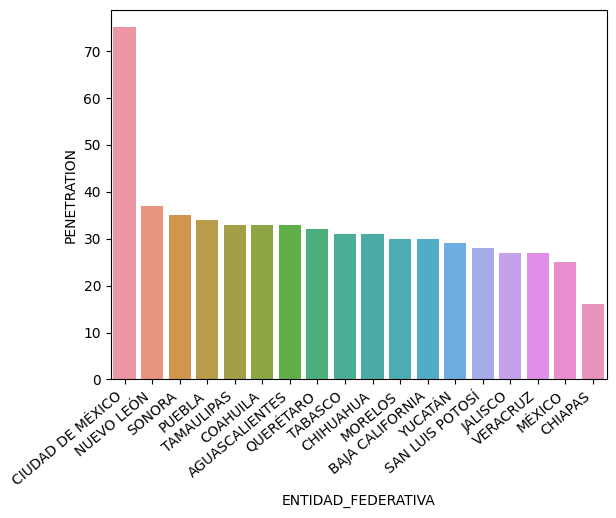

In [32]:
#SE GRAFICA LA PENETRACION
sns.barplot(x = 'ENTIDAD_FEDERATIVA', y = 'PENETRATION', data = bonus_penetration_states)
 
# Show the plot
plt.xticks(rotation = 40, ha = 'right')
plt.show()

#bonus_penetration_states.plot(x ='ENTIDAD_FEDERATIVA', kind = 'barh',y='PENETRATION')
#plt.show()